In [1]:
from fetch.match_results import read_joined

df, player_mapping, inverse_player_mapping = read_joined()

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [18]:
sorted(df.columns)

['__surface__',
 'atp',
 'avgl',
 'avgw',
 'b&wl',
 'b&ww',
 'b365l',
 'b365w',
 'best of',
 'best_of_5',
 'cbl',
 'cbw',
 'comeback_diff',
 'comment',
 'court',
 'date',
 'exl',
 'exw',
 'fatigue_diff',
 'fatigue_diff*best_of_5',
 'fatigue_games_diff',
 'fatigue_games_diff*best_of_5',
 'gbl',
 'gbw',
 'iwl',
 'iww',
 'l1',
 'l2',
 'l3',
 'l4',
 'l5',
 'lbl',
 'lbw',
 'lgames',
 'location',
 'loser',
 'lpts',
 'lrank',
 'lsets',
 'match_id',
 'maxl',
 'maxw',
 'p1',
 'p1_b365',
 'p1_fatigue_games',
 'p1_fatigue_matches',
 'p1_games',
 'p1_idx',
 'p1_last_retired',
 'p1_name',
 'p1_odds',
 'p1_rank',
 'p1_time_since_last_match',
 'p2',
 'p2_b365',
 'p2_fatigue_games',
 'p2_fatigue_matches',
 'p2_games',
 'p2_idx',
 'p2_last_retired',
 'p2_name',
 'p2_odds',
 'p2_rank',
 'p2_time_since_last_match',
 'player_x',
 'player_y',
 'psl',
 'psw',
 'retire_diff',
 'round',
 'sbl',
 'sbw',
 'series',
 'sjl',
 'sjw',
 'surface',
 'time_diff',
 'total_games',
 'tournament',
 'ubl',
 'ubw',
 'unname

In [23]:
df[['lrank', 'lpts', 'wrank', 'wpts']].tail()

,lrank,lpts,wrank,wpts
46522,95.0,639.0,8.0,3345.0
46523,22.0,1757.0,43.0,1128.0
46524,9.0,3125.0,3.0,5195.0
46525,43.0,1128.0,3.0,5195.0
46526,7.0,3545.0,3.0,5195.0


In [2]:
from fetch.helpers import get_train_test_split

train, test = get_train_test_split(
    df,
    '2015-01-01',
    min_train_date=None,
    max_test_date='2017-01-01',
    test_surface='Hard'
)

Removing walkovers...
Filtering dates and splitting...


In [3]:
from models.logit.base import get_X_y

train_X, train_y = get_X_y(train, player_mapping)
test_X, test_y = get_X_y(test, player_mapping)

In [4]:
dense_train_X = train_X.todense()

In [5]:
dense_test_X = test_X.todense()

In [6]:
dense_train_X.nbytes / (1024. * 1024.)

387.2566223144531

387 MB, so that's fine...

#### First, Fit Logit Through SKLearn
Tune L2 regularization penalty...

In [12]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

out = []
for exp in np.linspace(-5, 5, 100):
    C = 10 ** exp
    logit = LogisticRegression(C=C, fit_intercept=False)
    logit.fit(train_X, train_y)
    test_preds = zip(*logit.predict_proba(test_X))[1]
    auc = roc_auc_score(test_y, test_preds)
    print (C, auc)
    out.append((C, auc))

(1e-05, 0.7038314525138424)
(1.2618568830660211e-05, 0.7038381155232573)
(1.5922827933410938e-05, 0.7038381155232573)
(2.0092330025650458e-05, 0.7038381155232573)
(2.5353644939701114e-05, 0.7038381155232573)
(3.199267137797385e-05, 0.7038414470279647)
(4.037017258596558e-05, 0.703843668031103)
(5.0941380148163754e-05, 0.7038514415420869)
(6.428073117284319e-05, 0.7038669885640548)
(8.111308307896872e-05, 0.7038903090970068)
(0.00010235310218990269, 0.7039252898964348)
(0.0001291549665014884, 0.7039486104293865)
(0.00016297508346206434, 0.7040219035329497)
(0.00020565123083486514, 0.7041051911506351)
(0.00025950242113997375, 0.704191810273028)
(0.00032745491628777284, 0.7044316786119618)
(0.00041320124001153346, 0.7046648839414811)
(0.0005214008287999684, 0.7049413988321965)
(0.0006579332246575682, 0.7053145273594272)
(0.0008302175681319744, 0.7056554513411527)
(0.001047615752789665, 0.7059719442883572)
(0.0013219411484660286, 0.7065238635682192)
(0.0016681005372000592, 0.70711020839672

Text(0,0.5,'AUC')

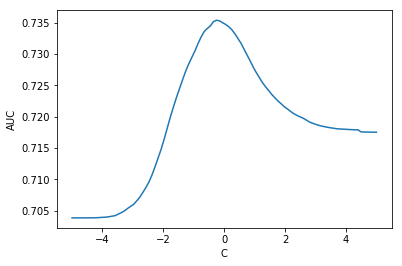

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

tuning_df = pd.DataFrame(out, columns=['C', 'auc'])
plt.plot(np.log(tuning_df['C']) / np.log(10), tuning_df['auc'])
plt.xlabel("C")
plt.ylabel("AUC")

In [15]:
tuning_df.sort('auc', ascending=False).head()

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


,C,auc
47,0.559081,0.735365
48,0.705480,0.735261
46,0.443062,0.735146
49,0.890215,0.734958
50,1.123324,0.734688


#### Now, Replicate Logit through Keras

In [ ]:
from keras.metrics import binary_accuracy
from keras.models import Model
from keras import layers


N_PLAYERS = len(player_mapping)

input_layer = layers.Input(shape=(N_PLAYERS,))
hidden_layer = layers.Dense(1, activation='linear', use_bias=False)(input_layer)
output = layers.Dense(1, activation='sigmoid', use_bias=False)(hidden_layer)

model = Model(inputs=input_layer, outputs=output)
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=[binary_accuracy]
)

In [ ]:
from keras.callbacks import EarlyStopping

model.fit(
    x=dense_train_X,
    y=train_y,
    batch_size=1000,
    epochs=1000,
    verbose=1,
    validation_data=(dense_test_X, test_y),
    callbacks=[EarlyStopping(monitor='loss', min_delta=0.000000001)],
    shuffle=True
)

In [ ]:
from sklearn.metrics import roc_auc_score

preds = model.predict(test_X)
roc_auc_score(test_y, preds)

In [ ]:
# Accuracy from just using rank
(test['y'] == (test['p1_rank'] < test['p2_rank']).astype(int)).mean()

Accuracy from ranks is pretty good -- is this an unfair comparison with our model though?  The ranks update over time...

#### Now, Include Interaction Terms...
Now, we see if we can improve the performance of our model by including player-loading-derived interaction terms...